#### EDA of the Pull Request Data between January 2018 and December 2023

Importing necessary libraries

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import ast
from collections import defaultdict
import os
sns.set(style="whitegrid")
%matplotlib inline

Section 1: Defining File Paths


In [22]:
COVID_PHASES = {
    "pre": ("2018-01-01", "2020-01-29"),
    "during": ("2020-01-30", "2023-05-05"),
    "post": ("2023-05-06", "2023-12-31")
}

REPOS = {
    "scikit-learn": "../data/raw/scikit-learn/scikit-learn_prs_2018_2023.csv",
    "pytorch": "../data/raw/pytorch/pytorch_prs_2018_2023.csv",
    "kubernetes": "../data/raw/kubernetes/kubernetes_prs_2018_2023.csv",
    "apache-spark": "../data/raw/apache/apache_spark_prs_2018_2023.csv"
}

KNOWN_BOTS = {
    "dependabot", "appveyorbot", "bors", "codecov", "coveralls", "circleci", "travis-ci",
    "github-actions", "jenkins", "azure-pipelines", "humbug", "neco-bot", "pyup-bot",
    "automerge", "rebase-bot", "auto-merge", "ci-bot", "codecov-commenter", "scikit-learn-bot", "pytorchupdatebot"
}

# Initial schema inspection
for repo, path in REPOS.items():
    df = pd.read_csv(path, parse_dates=["created_at", "closed_at", "merged_at"])
    print(f"{repo} — Rows: {len(df)}, Columns: {df.columns.tolist()}")

scikit-learn — Rows: 10766, Columns: ['pr_number', 'title', 'state', 'created_at', 'closed_at', 'merged_at', 'author', 'merged_by', 'assignees', 'reviewers', 'commit_authors', 'comment_authors', 'review_comment_authors']
pytorch — Rows: 75414, Columns: ['pr_number', 'title', 'state', 'created_at', 'closed_at', 'merged_at', 'author', 'merged_by', 'assignees', 'reviewers', 'commit_authors', 'comment_authors', 'review_comment_authors']
kubernetes — Rows: 43416, Columns: ['pr_number', 'title', 'state', 'created_at', 'closed_at', 'merged_at', 'author', 'merged_by', 'assignees', 'reviewers', 'commit_authors', 'comment_authors', 'review_comment_authors']
apache-spark — Rows: 24387, Columns: ['pr_number', 'title', 'state', 'created_at', 'closed_at', 'merged_at', 'author', 'merged_by', 'assignees', 'reviewers', 'commit_authors', 'comment_authors', 'review_comment_authors']


Section 1.1: Inspecting Raw Data

In [23]:
# Basic structure overview for each repository
for repo, path in REPOS.items():
    print(f"\n{'='*40}\nRepository: {repo}\n{'='*40}")
    df = pd.read_csv(path, parse_dates=["created_at", "closed_at", "merged_at"])
    print("\nColumns:")
    print(df.columns.tolist())
    
    print("\nData Types:")
    print(df.dtypes)
    
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    print("\nSample Rows:")




Repository: scikit-learn

Columns:
['pr_number', 'title', 'state', 'created_at', 'closed_at', 'merged_at', 'author', 'merged_by', 'assignees', 'reviewers', 'commit_authors', 'comment_authors', 'review_comment_authors']

Data Types:
pr_number                               int64
title                                  object
state                                  object
created_at                datetime64[ns, UTC]
closed_at                 datetime64[ns, UTC]
merged_at                 datetime64[ns, UTC]
author                                 object
merged_by                             float64
assignees                              object
reviewers                              object
commit_authors                         object
comment_authors                        object
review_comment_authors                 object
dtype: object

Missing Values:
pr_number                     0
title                         0
state                         0
created_at                    0
closed_at 

Section 2: Defining Helper Functions

In [24]:
import pandas as pd 
from collections import Counter 

def assign_covid_phase(date):
    if pd.notnull(date):
        if hasattr(date, "tzinfo") and date.tzinfo is not None:
            date = date.tz_convert(None)
    for phase, (start, end) in COVID_PHASES.items():
        if pd.to_datetime(start) <= date <= pd.to_datetime(end):
            return phase
    return None


def load_and_process_repo(repo_name, file_path):
    df = pd.read_csv(file_path, parse_dates=["created_at", "closed_at", "merged_at"])
    for col in ["created_at", "closed_at", "merged_at"]:
        df[col] = df[col].apply(lambda x: x.tz_convert(None) if pd.notnull(x) and hasattr(x, 'tz_convert') else x)
    df["title"].fillna("No Title", inplace=True)
    df["covid_phase"] = df["created_at"].apply(assign_covid_phase)
    df["repo"] = repo_name
    return df


def detect_bots_per_repo(df, repo_name):
    user_counts = Counter()
    user_roles = {}
    list_fields = ["commit_authors", "comment_authors", "review_comment_authors"]

    def parse_field(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return []
        return x if isinstance(x, list) else []

    for field in list_fields:
        df[field] = df[field].apply(parse_field)

    for _, row in df.iterrows():
        if pd.notnull(row["author"]):
            user_counts[row["author"]] += 1
            user_roles.setdefault(row["author"], set()).add("author")
        for field in list_fields:
            for user in row[field]:
                user_counts[user] += 1
                user_roles.setdefault(user, set()).add(field)

    records = []
    for user, count in user_counts.items():
        roles = list(user_roles[user])
        u_lower = user.lower()
        is_known = u_lower in KNOWN_BOTS
        only_comments = set(roles).issubset({"comment_authors", "review_comment_authors"})
        high_volume = count > 500
        suspected = is_known or only_comments or high_volume
        records.append({
            "repository": repo_name,
            "username": user,
            "mention_count": count,
            "roles": roles,
            "is_known_bot": is_known,
            "only_comments": only_comments,
            "high_volume": high_volume,
            "suspected_bot": suspected
        })

    bots_df = pd.DataFrame(records)
    suspected_bots = set(bots_df[bots_df["suspected_bot"]]["username"])

    df["author"] = df["author"].apply(lambda x: None if x in suspected_bots else x)
    for col in list_fields:
        df[col] = df[col].apply(lambda lst: [u for u in lst if u not in suspected_bots])

    return df, bots_df


Section 3: Load and Clean Data per Repo

In [25]:
def extract_contributors(row):
    contributors = set()
    for col in ["author", "merged_by", "assignees", "reviewers", "commit_authors", "comment_authors", "review_comment_authors"]:
        val = row[col]
        if isinstance(val, list):
            contributors.update(val)
        elif pd.notnull(val):
            contributors.add(val)
    return list(contributors)

repo_data = {}

for repo, path in REPOS.items():
    df = load_and_process_repo(repo, path)
    df_cleaned, bots = detect_bots_per_repo(df, repo)

    df_cleaned["all_contributors"] = df_cleaned.apply(extract_contributors, axis=1)

    repo_data[repo] = {
        "cleaned_df": df_cleaned,
        "bots": bots
    }


Section 4: Summary Table

In [26]:
summary_rows = []

for repo, content in repo_data.items():
    df = content["df"]
    bots = content["bots"]
    df_exploded = df.explode("all_contributors")
    df_exploded = df_exploded[df_exploded["all_contributors"].apply(lambda x: isinstance(x, str) and x.strip() != "")]

    pr_counts = df["covid_phase"].value_counts().to_dict()
    contributor_counts = df_exploded.groupby("covid_phase")["all_contributors"].nunique().to_dict()
    bot_count = bots["suspected_bot"].sum()

    summary_rows.append({
        "repository": repo,
        "total_prs": len(df),
        "total_contributors": df_exploded["all_contributors"].nunique(),
        "bots_detected": bot_count,
        "prs_pre": pr_counts.get("pre", 0),
        "prs_during": pr_counts.get("during", 0),
        "prs_post": pr_counts.get("post", 0),
        "contributors_pre": contributor_counts.get("pre", 0),
        "contributors_during": contributor_counts.get("during", 0),
        "contributors_post": contributor_counts.get("post", 0),
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("../data/processed/repo_summary_overview.csv", index=False)
display(summary_df)

KeyError: 'df'

Section 5: PR Activity Over Time

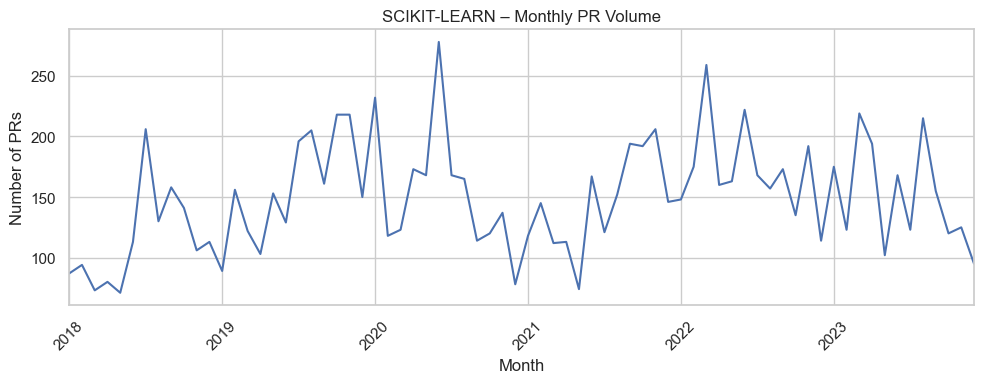

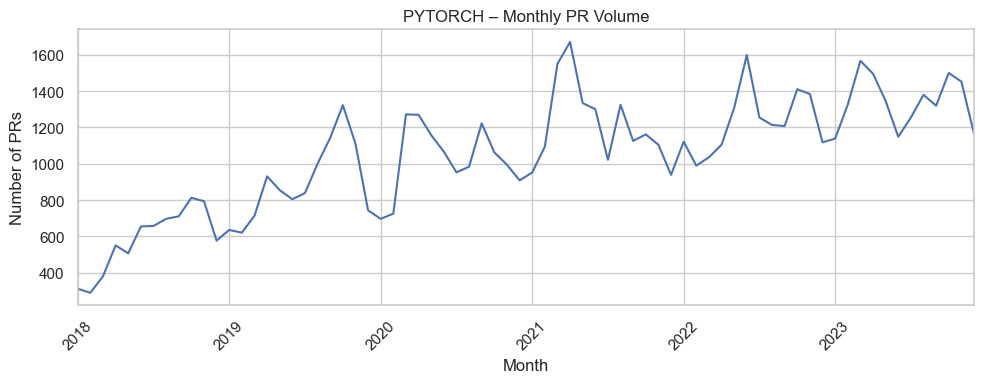

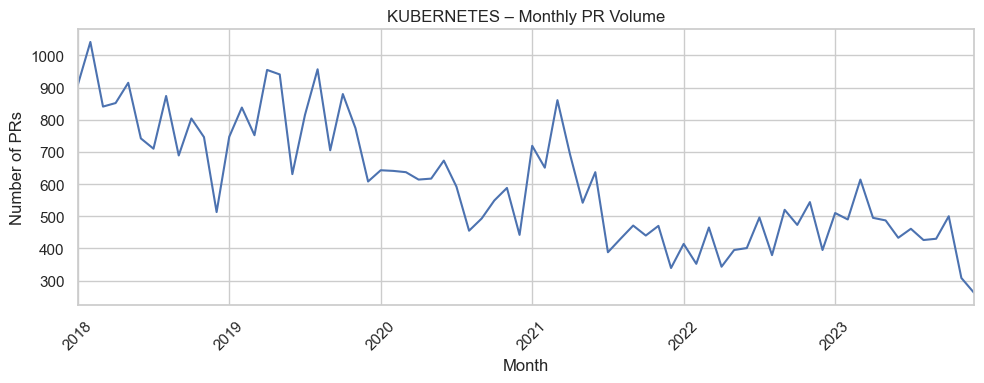

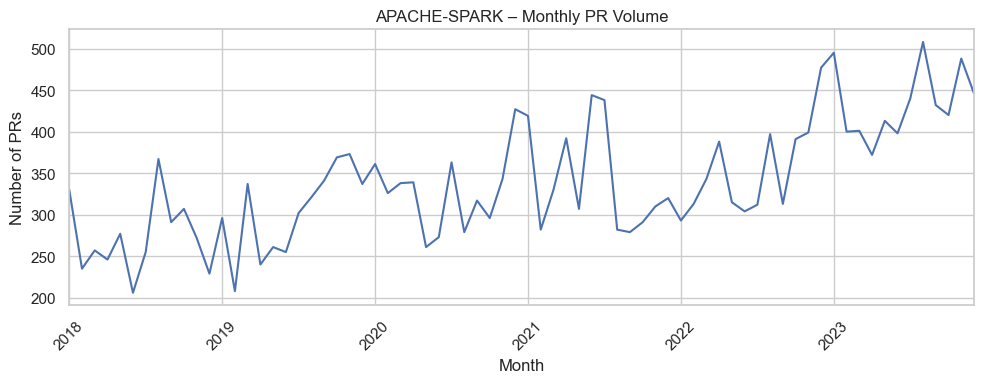

In [ ]:
for repo, content in repo_data.items():
    df = content["df"]
    df["month"] = df["created_at"].dt.to_period("M")
    monthly = df.groupby("month")["pr_number"].count()

    monthly.plot(figsize=(10, 4), title=f"{repo.upper()} – Monthly PR Volume")
    plt.ylabel("Number of PRs")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Section 6: PR Duration and Merge Rates

In [20]:
df["pr_duration_days"] = (df["closed_at"] - df["created_at"]).dt.days
df["is_merged"] = df["merged_at"].notnull()

median_durations = df.groupby(["repo", "covid_phase"])["pr_duration_days"].median().unstack()
merge_rates = df.groupby(["repo", "covid_phase"])["is_merged"].mean().unstack()

print("Median PR Duration (days):")
print(median_durations)

print("\nMerge Rates per Phase:")
print(merge_rates)


Median PR Duration (days):
covid_phase   during  post  pre
repo                           
apache-spark     1.0   0.0  3.0

Merge Rates per Phase:
covid_phase     during      post  pre
repo                                 
apache-spark  0.000146  0.000288  0.0


Section 7: Contributor Role Breakdown

In [9]:
from collections import defaultdict

role_counts = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    phase = row["covid_phase"]
    if pd.notnull(row["author"]):
        role_counts["author"][phase] += 1
    for col in ["reviewers", "comment_authors", "review_comment_authors"]:
        for user in row[col]:
            role_counts[col][phase] += 1

# Convert to DataFrame for display
import pandas as pd
role_df = pd.DataFrame(role_counts).fillna(0).astype(int)
print("Role Counts by COVID Phase:")
print(role_df)


Role Counts by COVID Phase:
        reviewers  author  review_comment_authors  comment_authors
pre         16187    3308                    3282             4876
None           67      20                      15               16
during      38295    4734                    3911             5050
post         9886    1314                     967             1182


Section 8: Save Cleaned Data

In [10]:
for repo, content in repo_data.items():
    content["df"].to_csv(f"../data/processed/{repo}_cleaned_prs.csv", index=False)
    content["bots"].to_csv(f"../data/processed/{repo}_detected_bots.csv", index=False)
#

Section 9: Save a Summary Table Per Repo

In [11]:
summary_rows = []

for repo, content in repo_data.items():
    df = content["df"]
    bots = content["bots"]

    pr_counts = df["covid_phase"].value_counts().to_dict()
    contributor_counts = df.explode("all_contributors").groupby("covid_phase")["all_contributors"].nunique().to_dict()
    bot_count = bots["suspected_bot"].sum()

    summary_rows.append({
        "repository": repo,
        "total_prs": len(df),
        "total_contributors": df["all_contributors"].explode().nunique(),
        "bots_detected": bot_count,
        "prs_pre": pr_counts.get("pre", 0),
        "prs_during": pr_counts.get("during", 0),
        "prs_post": pr_counts.get("post", 0),
        "contributors_pre": contributor_counts.get("pre", 0),
        "contributors_during": contributor_counts.get("during", 0),
        "contributors_post": contributor_counts.get("post", 0),
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("../data/processed/repo_summary_overview.csv", index=False)
display(summary_df)


,repository,total_prs,total_contributors,bots_detected,prs_pre,prs_during,prs_post,contributors_pre,contributors_during,contributors_post
0,scikit-learn,10766,2809,446,3436,6211,1085,1144,1634,300
1,pytorch,75414,13120,1122,18264,46773,10265,3096,8651,2799
2,kubernetes,43416,28789,1706,19803,20341,3213,14113,15567,3665
3,apache-spark,24387,2115,795,7229,13654,3475,956,1239,445


Section 10: Contributor Overlap and Survival Rates

In [12]:
# Get sets of contributors per phase
df_exploded = df.explode("all_contributors")  # Make sure this is already done above

pre_contributors = set(df_exploded[df_exploded["covid_phase"] == "pre"]["all_contributors"].dropna())
during_contributors = set(df_exploded[df_exploded["covid_phase"] == "during"]["all_contributors"].dropna())
post_contributors = set(df_exploded[df_exploded["covid_phase"] == "post"]["all_contributors"].dropna())

# Compute overlaps
pre_during_overlap = pre_contributors & during_contributors
during_post_overlap = during_contributors & post_contributors
pre_post_overlap = pre_contributors & post_contributors

# Print sizes and survival rates
print("Contributor Overlaps:")
print(f"Pre ∩ During: {len(pre_during_overlap)} ({len(pre_during_overlap) / len(pre_contributors):.2%} of Pre)")
print(f"During ∩ Post: {len(during_post_overlap)} ({len(during_post_overlap) / len(during_contributors):.2%} of During)")
print(f"Pre ∩ Post: {len(pre_post_overlap)} ({len(pre_post_overlap) / len(pre_contributors):.2%} of Pre)")


Contributor Overlaps:
Pre ∩ During: 276 (28.87% of Pre)
During ∩ Post: 244 (19.69% of During)
Pre ∩ Post: 86 (9.00% of Pre)


Section 11: Save Monthly PR Volume Plots

In [13]:
os.makedirs("../figures", exist_ok=True)

for repo, content in repo_data.items():
    df = content["df"]
    df["month"] = df["created_at"].dt.to_period("M")
    monthly = df.groupby("month")["pr_number"].count()

    fig, ax = plt.subplots(figsize=(10, 4))
    monthly.plot(ax=ax, title=f"{repo.upper()} – Monthly PR Volume")
    plt.ylabel("Number of PRs")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"../figures/{repo}_monthly_prs.png")
    plt.close()


Section 12: Top Contributers Per Phase

In [14]:
top_contributors_by_repo = {}

for repo, content in repo_data.items():
    df = content["df"]
    df_long = df.explode("all_contributors")

    top_per_phase = {}
    for phase in ["pre", "during", "post"]:
        filtered = df_long[df_long["covid_phase"] == phase]
        top = filtered["all_contributors"].value_counts().head(10)
        top_per_phase[phase] = top

    top_contributors_by_repo[repo] = top_per_phase
    # Save per repo
    for phase, data in top_per_phase.items():
        data.to_csv(f"../data/processed/{repo}_top_contributors_{phase}.csv", header=["count"])


Section 13: Contributor Overlap Across Phases

In [15]:
overlap_stats = defaultdict(dict)

for repo, content in repo_data.items():
    df = content["df"]
    df_long = df.explode("all_contributors")

    contributors_by_phase = {
        phase: set(df_long[df_long["covid_phase"] == phase]["all_contributors"].dropna())
        for phase in ["pre", "during", "post"]
    }

    # Jaccard overlap between phases
    overlap_stats[repo]["pre_during"] = len(contributors_by_phase["pre"] & contributors_by_phase["during"]) / max(len(contributors_by_phase["pre"] | contributors_by_phase["during"]), 1)
    overlap_stats[repo]["during_post"] = len(contributors_by_phase["during"] & contributors_by_phase["post"]) / max(len(contributors_by_phase["during"] | contributors_by_phase["post"]), 1)
    overlap_stats[repo]["pre_post"] = len(contributors_by_phase["pre"] & contributors_by_phase["post"]) / max(len(contributors_by_phase["pre"] | contributors_by_phase["post"]), 1)

overlap_df = pd.DataFrame.from_dict(overlap_stats, orient="index")
overlap_df.to_csv("../data/processed/contributor_overlap.csv")
display(overlap_df)


,pre_during,during_post,pre_post
scikit-learn,0.074246,0.042026,0.026297
pytorch,0.058002,0.072801,0.021310
kubernetes,0.113153,0.085634,0.037828
apache-spark,0.143825,0.169444,0.065399


Section 14: Contributor Role Breakdown

In [16]:
role_counts = defaultdict(lambda: defaultdict(int))

for _, row in df.iterrows():
    phase = row["covid_phase"]
    if pd.notnull(row["author"]):
        role_counts["author"][phase] += 1
    for col in ["reviewers", "comment_authors", "review_comment_authors"]:
        for user in row[col]:
            role_counts[col][phase] += 1

# Convert to DataFrame for display
import pandas as pd
role_df = pd.DataFrame(role_counts).fillna(0).astype(int)
print("Role Counts by COVID Phase:")
print(role_df)


Role Counts by COVID Phase:
        reviewers  author  review_comment_authors  comment_authors
pre         16187    3308                    3282             4876
None           67      20                      15               16
during      38295    4734                    3911             5050
post         9886    1314                     967             1182


Section 15: PR Duration Analysis

In [17]:
duration_stats = []

for repo, content in repo_data.items():
    df = content["df"].copy()

    df["closed_duration_days"] = (df["closed_at"] - df["created_at"]).dt.total_seconds() / 86400
    df["merged_duration_days"] = (df["merged_at"] - df["created_at"]).dt.total_seconds() / 86400

    durations = df.groupby("covid_phase")[["closed_duration_days", "merged_duration_days"]].median().reset_index()
    durations["repository"] = repo
    duration_stats.append(durations)

duration_df = pd.concat(duration_stats)
duration_df.to_csv("../data/processed/pr_durations_by_phase.csv", index=False)
display(duration_df)


,covid_phase,closed_duration_days,merged_duration_days,repository
0,during,2.150249,1.958113,scikit-learn
1,post,3.694317,3.749491,scikit-learn
2,pre,2.820758,1.824502,scikit-learn
0,during,3.343270,0.889664,pytorch
1,post,2.502390,0.642928,pytorch
2,pre,1.843449,0.643484,pytorch
0,during,8.187726,6.036956,kubernetes
1,post,9.897789,6.177095,kubernetes
2,pre,5.674248,4.140145,kubernetes
0,during,1.426262,0.675544,apache-spark


Section 16: Contributor Acyivity Over Time

In [18]:
# Add month and quarter columns
for repo, content in repo_data.items():
    df = content["df"]
    df["month"] = df["created_at"].dt.to_period("M")
    df["quarter"] = df["created_at"].dt.to_period("Q")
    df_exploded = df.explode("all_contributors")
    
    monthly_prs = df.groupby("month").size()
    monthly_contributors = df_exploded.groupby("month")["all_contributors"].nunique()

    print(f"{repo.upper()} - Monthly PRs and Contributors")
    print("Monthly PRs:")
    print(monthly_prs.tail())
    print("Monthly Unique Contributors:")
    print(monthly_contributors.tail())


SCIKIT-LEARN - Monthly PRs and Contributors
Monthly PRs:
month
2023-08    215
2023-09    155
2023-10    120
2023-11    125
2023-12     95
Freq: M, dtype: int64
Monthly Unique Contributors:
month
2023-08    92
2023-09    56
2023-10    52
2023-11    53
2023-12    42
Freq: M, Name: all_contributors, dtype: int64
PYTORCH - Monthly PRs and Contributors
Monthly PRs:
month
2023-08    1380
2023-09    1320
2023-10    1500
2023-11    1453
2023-12    1166
Freq: M, dtype: int64
Monthly Unique Contributors:
month
2023-08    650
2023-09    592
2023-10    665
2023-11    690
2023-12    531
Freq: M, Name: all_contributors, dtype: int64
KUBERNETES - Monthly PRs and Contributors
Monthly PRs:
month
2023-08    426
2023-09    430
2023-10    500
2023-11    308
2023-12    262
Freq: M, dtype: int64
Monthly Unique Contributors:
month
2023-08    764
2023-09    785
2023-10    817
2023-11    539
2023-12    467
Freq: M, Name: all_contributors, dtype: int64
APACHE-SPARK - Monthly PRs and Contributors
Monthly PRs:
mo

Section 17: New vs Returning Contributors per COVID Phase

In [19]:
for repo, content in repo_data.items():
    df = content["df"]
    df_exploded = df.explode("all_contributors")
    
    contributor_phases = df_exploded.groupby("all_contributors")["covid_phase"].unique()

    new_counts = {"pre": 0, "during": 0, "post": 0}
    returning_counts = {"pre": 0, "during": 0, "post": 0}

    for contributor, phases in contributor_phases.items():
        if "pre" in phases:
            new_counts["pre"] += 1
        if "during" in phases and "pre" not in phases:
            new_counts["during"] += 1
        elif "during" in phases:
            returning_counts["during"] += 1
        if "post" in phases and "during" not in phases and "pre" not in phases:
            new_counts["post"] += 1
        elif "post" in phases:
            returning_counts["post"] += 1

    print(f"{repo.upper()} - New vs Returning Contributors")
    print("New contributors:", new_counts)
    print("Returning contributors:", returning_counts)


SCIKIT-LEARN - New vs Returning Contributors
New contributors: {'pre': 1144, 'during': 1442, 'post': 216}
Returning contributors: {'pre': 0, 'during': 192, 'post': 84}
PYTORCH - New vs Returning Contributors
New contributors: {'pre': 3096, 'during': 8007, 'post': 2007}
Returning contributors: {'pre': 0, 'during': 644, 'post': 792}
KUBERNETES - New vs Returning Contributors
New contributors: {'pre': 14113, 'during': 12550, 'post': 2097}
Returning contributors: {'pre': 0, 'during': 3017, 'post': 1568}
APACHE-SPARK - New vs Returning Contributors
New contributors: {'pre': 956, 'during': 963, 'post': 195}
Returning contributors: {'pre': 0, 'during': 276, 'post': 250}


Section 18: Contributor Engagement Distribution

In [20]:
for repo, content in repo_data.items():
    df_exploded = content["df"].explode("all_contributors")
    contributor_counts = df_exploded["all_contributors"].value_counts()

    one_time = (contributor_counts == 1).sum()
    frequent = (contributor_counts >= 5).sum()

    print(f"{repo.upper()}")
    print(f"Total contributors: {len(contributor_counts)}")
    print(f"One-time contributors: {one_time}")
    print(f"Contributors with 5+ PRs: {frequent}")


SCIKIT-LEARN
Total contributors: 2809
One-time contributors: 1682
Contributors with 5+ PRs: 290
PYTORCH
Total contributors: 13120
One-time contributors: 8657
Contributors with 5+ PRs: 1856
KUBERNETES
Total contributors: 28789
One-time contributors: 19913
Contributors with 5+ PRs: 3726
APACHE-SPARK
Total contributors: 2115
One-time contributors: 991
Contributors with 5+ PRs: 522


Section 19: Top Contributors per Phase

In [21]:
for repo, content in repo_data.items():
    df_exploded = content["df"].explode("all_contributors")

    print(f"{repo.upper()} - Top Contributors per COVID Phase")
    for phase in ["pre", "during", "post"]:
        top = (df_exploded[df_exploded["covid_phase"] == phase]["all_contributors"]
               .value_counts()
               .head(10))
        print(f"Top in {phase}:")
        print(top)
        print("-" * 40)


SCIKIT-LEARN - Top Contributors per COVID Phase
Top in pre:
all_contributors
[]                    3428
agramfort              202
TomDLT                 150
jorisvandenbossche     113
GaelVaroquaux          105
['glemaitre']           66
albertcthomas           63
eamanu                  52
reshamas                52
jakirkham               33
Name: count, dtype: int64
----------------------------------------
Top in during:
all_contributors
[]               6200
Micky774          212
alfaro96          194
['glemaitre']     172
betatim           171
reshamas          156
lucyleeow         143
TomDLT            137
ArturoAmorQ       113
jmloyola           81
Name: count, dtype: int64
----------------------------------------
Top in post:
all_contributors
[]                1085
betatim            114
OmarManzoor         78
Charlie-XIAO        64
ArturoAmorQ         63
Micky774            44
lucyleeow           43
Tialo               42
StefanieSenger      38
['glemaitre']       25
Name: c

Section 20: Final Dataset Summary

In [22]:
# Recompute missing derived columns
for repo, content in repo_data.items():
    df = content["df"]

    # Duration and merge flag
    df["pr_duration_days"] = (df["closed_at"] - df["created_at"]).dt.days
    df["is_merged"] = df["merged_at"].notnull()

    # Store it back
    content["df"] = df


for repo, content in repo_data.items():
    df = content["df"]
    df_exploded = df.explode("all_contributors")

    total_prs = len(df)
    total_contributors = df_exploded["all_contributors"].nunique()
    median_duration = df["pr_duration_days"].median()
    merge_rate = df["is_merged"].mean()

    print(f"{repo.upper()} - Dataset Summary")
    print(f"Total PRs: {total_prs}")
    print(f"Total contributors: {total_contributors}")
    print(f"Median PR duration: {median_duration:.2f} days")
    print(f"Merge rate: {merge_rate:.2%}")
    print("-" * 50)


SCIKIT-LEARN - Dataset Summary
Total PRs: 10766
Total contributors: 2809
Median PR duration: 2.00 days
Merge rate: 75.61%
--------------------------------------------------
PYTORCH - Dataset Summary
Total PRs: 75414
Total contributors: 13120
Median PR duration: 2.00 days
Merge rate: 5.16%
--------------------------------------------------
KUBERNETES - Dataset Summary
Total PRs: 43416
Total contributors: 28789
Median PR duration: 6.00 days
Merge rate: 68.47%
--------------------------------------------------
APACHE-SPARK - Dataset Summary
Total PRs: 24387
Total contributors: 2115
Median PR duration: 1.00 days
Merge rate: 0.01%
--------------------------------------------------


### Now to add some visualizations

Section 21: PR Volume and Contributors Over Time

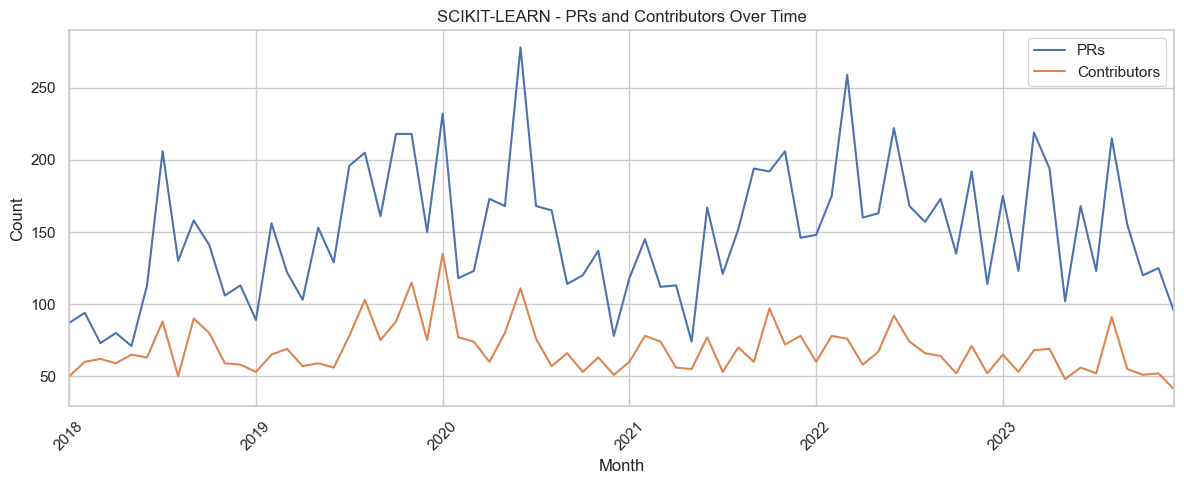

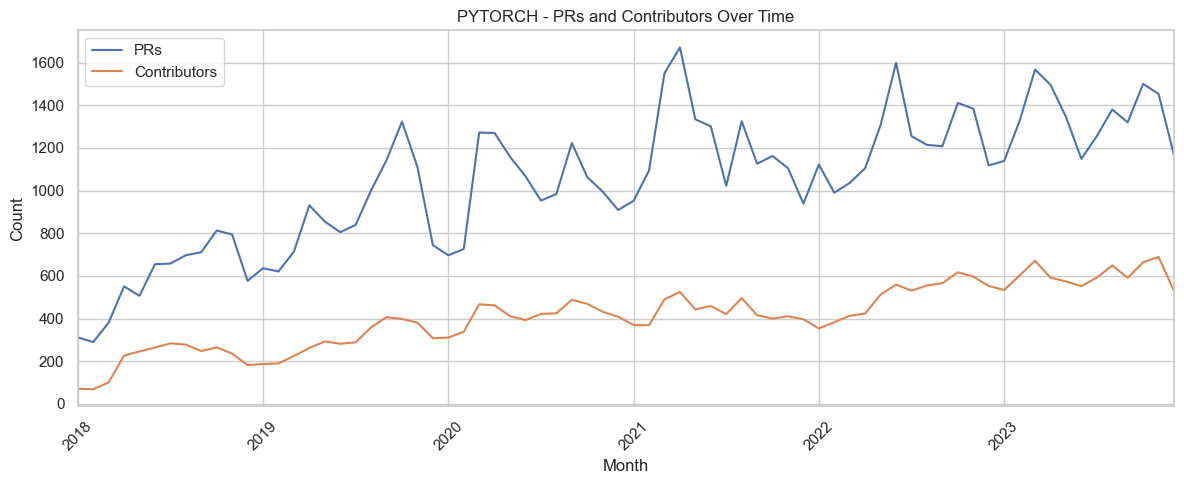

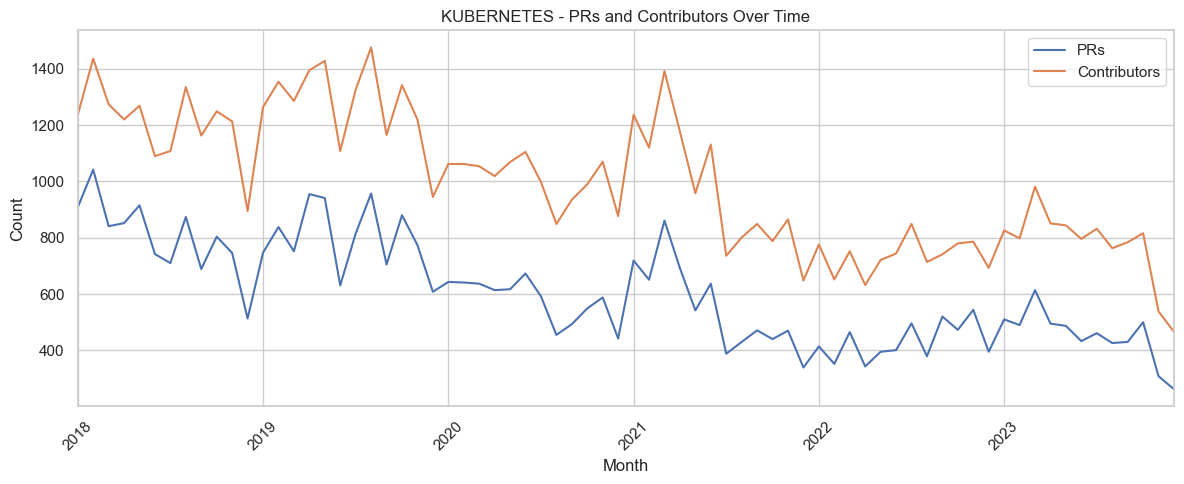

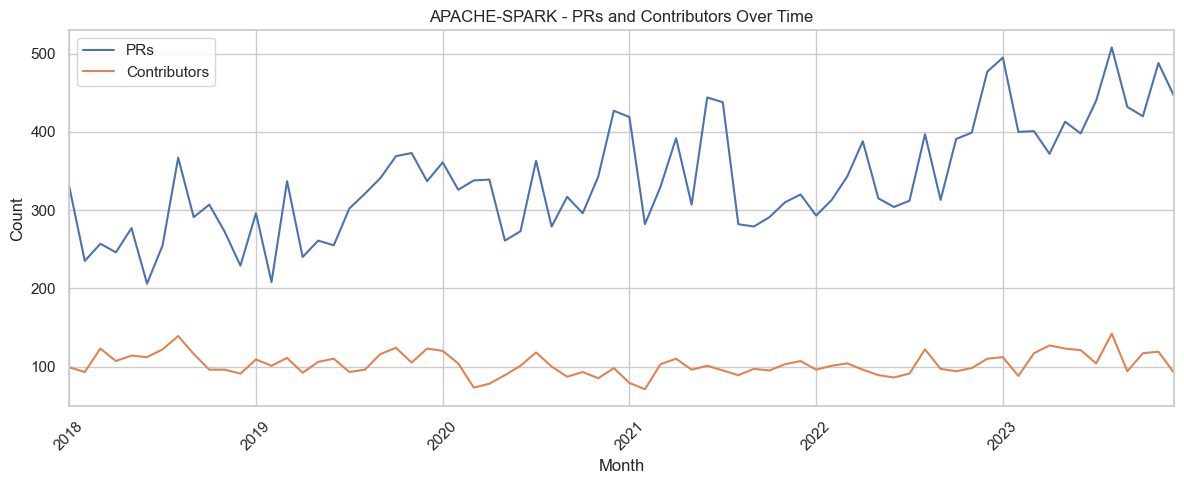

In [23]:
for repo, content in repo_data.items():
    df = content["df"].copy()
    df["month"] = df["created_at"].dt.to_period("M")
    df["quarter"] = df["created_at"].dt.to_period("Q")
    df_exploded = df.explode("all_contributors")
    
    # Clean contributors
    df_exploded = df_exploded[df_exploded["all_contributors"].notnull()]
    df_exploded = df_exploded[df_exploded["all_contributors"].astype(str).str.strip() != ""]
    df_exploded = df_exploded[df_exploded["all_contributors"] != "[]"]
    
    prs_per_month = df.groupby("month").size()
    contributors_per_month = df_exploded.groupby("month")["all_contributors"].nunique()

    plt.figure(figsize=(12, 5))
    prs_per_month.plot(label="PRs", legend=True)
    contributors_per_month.plot(label="Contributors", legend=True)
    plt.title(f"{repo.upper()} - PRs and Contributors Over Time")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
